In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import PIL
import imageio

import utils

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train, x_test = utils.preprocess_binarize(x_train), utils.preprocess_binarize(x_test)

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [3]:
# Constants definition
TRAIN_SIZE = x_train.shape[0]
TEST_SIZE = x_test.shape[0]
BATCH_SIZE = 32

# Shuffle and batch data using tf dataset
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(TRAIN_SIZE).batch(BATCH_SIZE).cache()
test_ds = tf.data.Dataset.from_tensor_slices(x_test).shuffle(TEST_SIZE).batch(BATCH_SIZE).cache()

In [4]:
# VAE definition
class VAE(keras.models.Model):
    def __init__(self, latent_dims, input_shape):
        super(VAE, self).__init__()
        
        self.latent_dims = latent_dims
        self.image_shape = input_shape
        
        # Encoder model
        self.encoder = keras.Sequential([
            keras.layers.InputLayer(input_shape=self.image_shape),
            keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu'),
            keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(self.latent_dims + self.latent_dims)
        ])
        
        # Decoder model
        self.decoder = keras.Sequential([
            keras.layers.InputLayer(input_shape=(self.latent_dims, )),
            keras.layers.Dense(7*7*32, activation='relu'),
            keras.layers.Reshape(target_shape=(7, 7, 32)),
            keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
            keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same'),
        ])
    
    # Encodes input and outputs mean and log variance
    def encode(self, x):
        mu, log_sigma_sq = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mu, log_sigma_sq
    
    # Reparameterization trick
    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=mean.shape)
        z = mean + epsilon * tf.exp(log_var * 0.5)
        return z
    
    # Decodes z
    def decode(self, z, apply_sigmoid=False):
        z_decoded_logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(z_decoded_logits)
        return z_decoded_logits
    
    # Samples from decoded z or randomly choosen z
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dims))
        return self.decode(z, apply_sigmoid=True)

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log_2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log_2pi),
      axis=raxis)


def compute_loss(model, x):
  mu, log_var = model.encode(x)
  z = model.reparameterize(mu, log_var)
  logits = model.decode(z)
  reconst_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x)
  logpx_z = -tf.reduce_sum(reconst_loss, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mu, log_var)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Training step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [36]:
# Training constants definition
EPOCHS = 10
LATENT_DIMS = 2
NUM_EXAMPLES = 16
INPUT_SHAPE = x_train.shape[1:]

# Random vector for generation
random_vector_for_generation = tf.random.normal(shape=(NUM_EXAMPLES, LATENT_DIMS))

In [37]:
# VAE initialization
vae = VAE(latent_dims=LATENT_DIMS, input_shape=INPUT_SHAPE)

In [38]:
# Generate and save image at each epoch
def generate_and_save_at_epoch(model, epoch, x):
    mean, log_var = model.encode(x)
    z = model.reparameterize(mean, log_var)
    output = model.sample(z)
    
    plt.figure(figsize=(4, 4))
    for i in range(output.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(output[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'generated-images/image_at_epoch__{epoch}.png')
    plt.show()

In [39]:
import os

if not os.path.isdir('generated-images'):
    os.mkdir('generated-images')

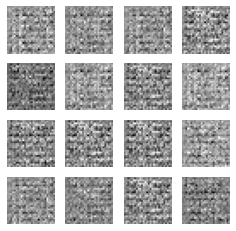

In [40]:
# Sample a set from test set to generate images before training
for test_batch in test_ds.take(1):
    test_sample = test_batch[0:NUM_EXAMPLES, :, :, :]

generate_and_save_at_epoch(vae, 0, test_sample)

Epoch: 1 | ELBO: -151.8083038330078 | duration: 14 seconds


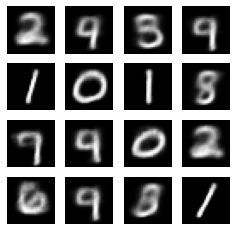

Epoch: 2 | ELBO: -151.0827178955078 | duration: 9 seconds


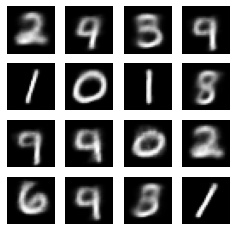

Epoch: 3 | ELBO: -150.64111328125 | duration: 10 seconds


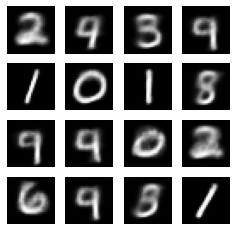

Epoch: 4 | ELBO: -150.0726776123047 | duration: 10 seconds


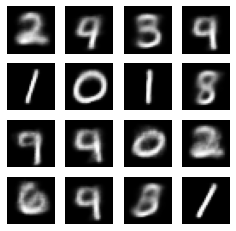

Epoch: 5 | ELBO: -149.76580810546875 | duration: 9 seconds


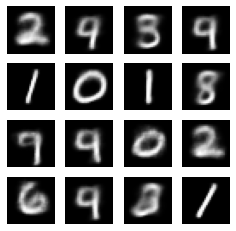

Epoch: 6 | ELBO: -149.81150817871094 | duration: 9 seconds


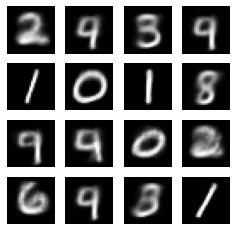

Epoch: 7 | ELBO: -149.5233917236328 | duration: 10 seconds


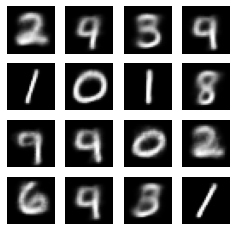

Epoch: 8 | ELBO: -149.26417541503906 | duration: 9 seconds


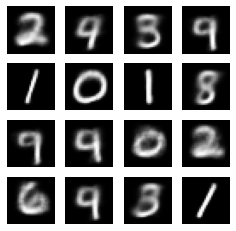

Epoch: 9 | ELBO: -149.63539123535156 | duration: 9 seconds


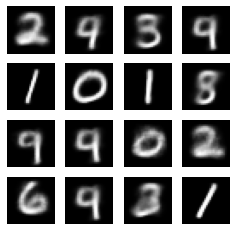

Epoch: 10 | ELBO: -149.21066284179688 | duration: 9 seconds


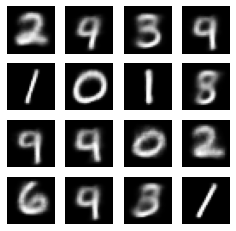

In [44]:
# Training loop
import time, math

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    for train_x in train_ds:
        train_step(vae, train_x, optimizer)
    end = time.time()
    
    loss = keras.metrics.Mean()
    for test_x in test_ds:
        loss(compute_loss(vae, test_x))
    elbo = -loss.result()
    print(f'Epoch: {epoch} | ELBO: {elbo} | duration: {math.ceil(end - start)} seconds')
    generate_and_save_at_epoch(vae, epoch, test_sample)

In [57]:
# Make a gif from saved images
import glob

gif_file = 'vae_mnist.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = sorted(glob.glob('generated-images/image*.png'))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\Rajat\AppData\Local\Temp\ipykernel_12964\1268899913.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


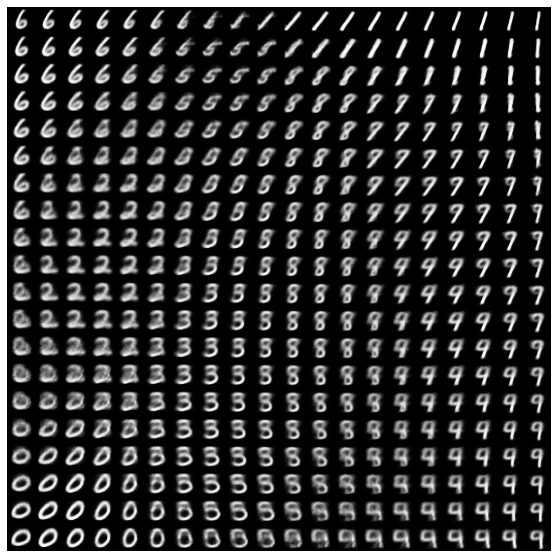

In [64]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

plot_latent_images(vae, 20)